In [110]:
import math as mth
import numpy as np
import pandas as pd
import scipy.integrate as spi
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from tqdm.notebook import tqdm
plt.rcParams['font.family'] = 'Times New Roman'


In [74]:
class BufferSize() :
    
    ## Initialize 
    def __init__(self, size_dist_para, mu, lamb, B):
        
        # size_dist_para : tuple of float arrays, ( p , a ) specifies the parameters of the mixture exponentials for job size, 
        #                  i.e., sum( pi * ai * exp(-ai * x) ), x bytes per job
        #       mu       : float, transmission rate, bytes per sec
        #      lamb      : float, job arrival rate, jobs per sec
        #       B        : float, buffer size, bytes
        
        self.p = np.array(size_dist_para[0])
        self.a = np.array(size_dist_para[1])
        
        if self.p.sum() != 1.0 :
            raise ValueError("Invalid distibution given: integral not equals to 1.")
        
        self.k = len(self.p)
        self.mu , self.lamb , self.B = mu , lamb , B
        
        # Laplace transform for the complementary cdf of the mixture exponentials, whose input should be a float
        self.LFc = np.vectorize(lambda s : (self.p / (self.a + s)).sum())
        self.x_dist = np.vectorize(lambda x : ( self.p * self.a * np.exp(-self.a * x) ).sum()) # pdf of the given mixture exponentials
        
        self.mu_in = self.LFc(0) * self.lamb  # average data arrival rate, bytes per sec
        self.decay = self.mu_in < self.mu   
        
        self.s = None                         # singularities
        self.residue_coes = None              # coefficients for residues
        
        self.p1  = None    
        self.p0  = None   
        self.av_occupancy , self.occupancyRate = None , None
        self.delta_QoS , self.epsilon_QoS , self.t_QoS = None , None , None
        
    
    # Evaluate coefficeinets for prod([s+aj])
    def multiply_polynomials(self, a):
        result = [1]
        for aj in a :
            result = np.polymul(result, [1,aj])
        return result
    
    
    ## Fit the partially-rejected case    
    def fit_PR(self, display=False):   
       
        # compute the coefficients for the polynomial, whose roots gives the singularities
        coes = self.mu * self.multiply_polynomials(self.a)
        
        for j in range(self.k) :
            a_temp = np.concatenate((self.a[:j], self.a[j+1:]))
            coes[1:] -= self.lamb * self.p[j] * self.multiply_polynomials(a_temp)
            
        # compute the singularities
        self.s = np.roots(coes)  
        
        # apply the residue theorem
        LFc_s = self.LFc(self.s) 
        numerator_s = self.lamb * np.array([(s + self.a).prod() for s in self.s])
        denominator_s = self.mu * np.array([(s - self.s[self.s!=s]).prod() for s in self.s])
        self.residue_coes =  LFc_s * numerator_s / denominator_s
        
        # comopute the distribution
        g = lambda y :  (self.residue_coes * np.exp(self.s*y)).sum()
        g_int  = spi.quad(g, 0, self.B)[0]
        self.p0 = 1 / ( 1 + g_int )
        self.p1 = np.vectorize(lambda y : self.p0 * g(y))
    
        # compute the quality fo service QoS
        self.av_occupancy = spi.quad(lambda y : y*self.p1(y), 0, self.B)[0]
        self.occupancyRate = self.av_occupancy / self.B
        self.delta_QoS    = self.mu * self.p1(self.B) / self.lamb
        self.epsilon_QoS  = 1 - self.mu * (1-self.p0) / self.mu_in
        self.t_QoS        = self.av_occupancy / self.mu     
        
        if display:
            print('1) job arrival rate  : %.3f jobs / sec'%(self.lamb))
            print('2) average job size  : %.3f bytes / job'%(self.LFc(0)))
            print('3) data arrival rate : %.3f bytes / sec'%(self.mu_in))
            print('4) transmission rate : %.3f bytes / sec'%(self.mu))
            print('5) average occupency : %.3f / %.3f bytes, occupency rate %.3f%%'%(self.av_occupancy,self.B,self.occupancyRate*100))
            print('6) empty probability : %.3f'%(self.p0))
            print('7) delta_QoS  , job retransmission proportion  : %.3f%%'%(self.delta_QoS*100))
            print('8) epsilon_QoS, data retransmission proportion : %.3f%%'%(self.epsilon_QoS*100))
            print('9) t_QoS, average wait time : %.3f sec'%(self.t_QoS))

In [276]:
p = np.array([0.3,0.5,0.2])
a_size = np.array([0.5,1.5,2])
a = 1/a_size
size_dist_para = (p,a)
mu = 3
lamb = 2
B = 10

model = BufferSize(size_dist_para, mu, lamb, B)
model.fit_PR(display=True)

1) job arrival rate  : 2.000 jobs / sec
2) average job size  : 1.300 bytes / job
3) data arrival rate : 2.600 bytes / sec
4) transmission rate : 3.000 bytes / sec
5) average occupency : 3.338 / 10.000 bytes, occupency rate 33.379%
6) empty probability : 0.209
7) delta_QoS  , job retransmission proportion  : 7.335%
8) epsilon_QoS, data retransmission proportion : 8.781%
9) t_QoS, average wait time : 1.113 sec


# Analytical Result

## P1 Change

In [314]:
# mu > data arrival rate = 2.6 bytes / sec
p = np.array([0.3,0.5,0.2]) ; a_size = np.array([0.5,1.5,2]) ; size_dist_para = ( p , 1/a_size )
lamb = 2
mu1 = 2
mu2 = 3

Bs = np.linspace(1, 10, 10)
ys = []
p1s = [[],[]]

for B in Bs :
    model1 = BufferSize(size_dist_para, mu1, lamb, B)
    model2 = BufferSize(size_dist_para, mu2, lamb, B)
    
    model1.fit_PR()
    model2.fit_PR()
    
    y = np.linspace(0, B, 100)
    ys.append(y)
    
    p1s[0].append(model1.p1(y))
    p1s[1].append(model2.p1(y))
    


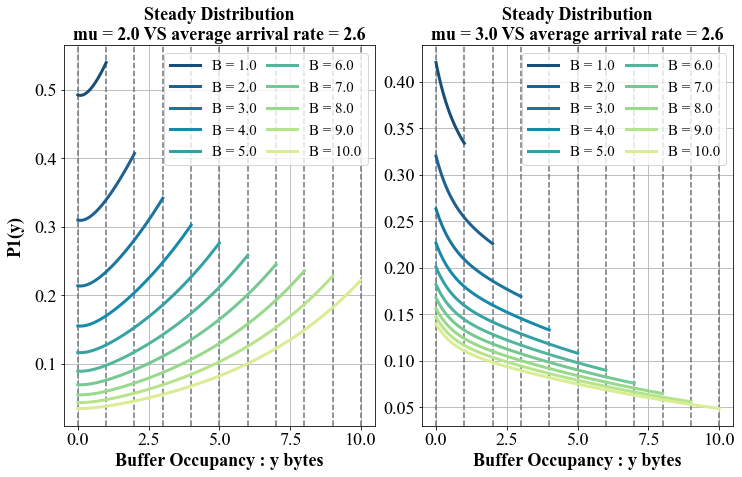

In [343]:
## Plot result
title_fontsize = 18
tick_size = 18
leg_size = 15
colors = ['#184e77','#1e6091','#1a759f','#168aad','#34a0a4','#52b69a','#76c893','#99d98c','#b5e48c','#d9ed92']
fig, ax = plt.subplots(1,2, figsize=( 12, 7 ))

for j in range(2):
    
    ax[j].axvline(x=0, color='#6c757d', linestyle='--')

    for i in range(len(ys)):
        ax[j].axvline(x=Bs[i], color='#6c757d', linestyle='--')
        ax[j].plot( ys[i] , p1s[j][i], label='B = %.1f'%(Bs[i]), linewidth=3, color=colors[i] )
        
    if j == 0 :
        ax[j].set_title('Steady Distribution\nmu = %.1f VS average arrival rate = 2.6'%mu1, fontsize=title_fontsize, fontweight='bold')
    else :
        ax[j].set_title('Steady Distribution\nmu = %.1f VS average arrival rate = 2.6'%mu2, fontsize=title_fontsize, fontweight='bold')
    
    if j == 0 :
        ax[j].set_ylabel('P1(y)', fontsize=title_fontsize, fontweight='bold', labelpad=10)  
        
    ax[j].set_xlabel('Buffer Occupancy : y bytes', fontsize=title_fontsize, fontweight='bold') 
    ax[j].tick_params(axis='y', labelsize=tick_size) 
    ax[j].tick_params(axis='x', labelsize=tick_size) 
    
    ax[j].legend(loc='upper right', fontsize=leg_size, ncol=2, columnspacing=0.7)
    ax[j].grid()

plt.subplots_adjust(wspace=0.15)
plt.show()

## QoS Change

In [196]:
lamb = 2
p = np.array([0.3,0.5,0.2]) ; a_size = np.array([0.5,1.5,2]) ; size_dist_para = ( p , 1/a_size )

mu = np.linspace(1,4, 100)
B  = np.linspace(1, 10, 100)
mu, B = np.meshgrid(mu, B)

occupancyRates = np.empty_like(mu)
emptyProbabilities = np.empty_like(mu)
deltas = np.empty_like(mu)     # job retransmission proportion
epsilons = np.empty_like(mu)   # data retransmission proportion
ts = np.empty_like(mu)         # average wait time
    
for i in tqdm(range(mu.shape[0])):
    for j in range(mu.shape[1]):
        model = BufferSize(size_dist_para, mu[i, j], lamb, B[i, j])
        model.fit_PR()
        occupancyRates[i,j] = model.occupancyRate
        emptyProbabilities[i,j] = model.p0
        deltas[i,j] = model.delta_QoS
        epsilons[i,j] = model.epsilon_QoS
        ts[i,j] = model.t_QoS

  0%|          | 0/100 [00:00<?, ?it/s]

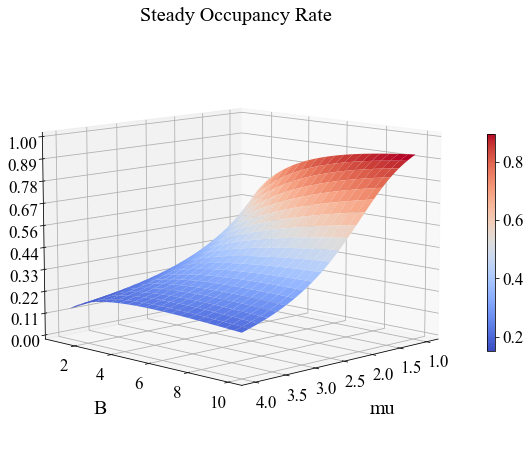

In [254]:
## Plot occupancy rate
title_fontsize = 10
tick_size = 17

fig, ax = plt.subplots(figsize=( 12, 8 ), subplot_kw={"projection": "3d"})
surf = ax.plot_surface(mu, B, occupancyRates, rstride=5, cstride=5, cmap='coolwarm')

ax.set_zlim(0.00, 1.00)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter('{x:.02f}')
cb = fig.colorbar(surf, shrink=0.5, aspect=25)
cb.ax.tick_params(labelsize=tick_size)

ax.set_xlabel('mu', fontsize=title_fontsize, labelpad=20)
ax.set_ylabel('B' , fontsize=title_fontsize, labelpad=20)
ax.set_title('Steady Occupancy Rate', fontsize=title_fontsize, pad=0)

ax.tick_params(axis='x', labelsize=tick_size)
ax.tick_params(axis='y', labelsize=tick_size)
ax.tick_params(axis='z', labelsize=tick_size)
ax.view_init(elev=10, azim=45)
plt.show()

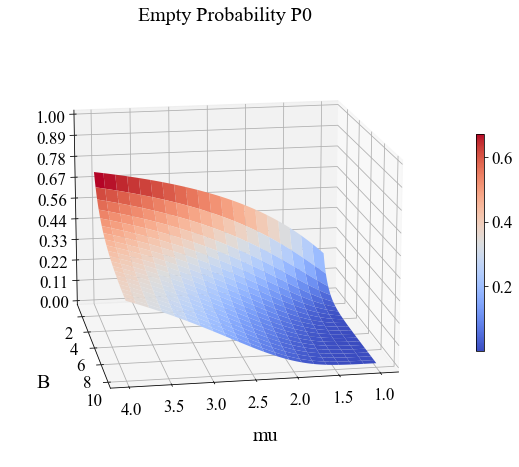

In [256]:
## Plot empty probabilities
title_fontsize = 10
tick_size = 17

fig, ax = plt.subplots(figsize=( 12, 8 ), subplot_kw={"projection": "3d"})
surf = ax.plot_surface(mu, B, emptyProbabilities, rstride=5, cstride=5, cmap='coolwarm')

ax.set_zlim(0.00, 1.00)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter('{x:.02f}')
cb = fig.colorbar(surf, shrink=0.5, aspect=25)
cb.ax.tick_params(labelsize=tick_size)

ax.set_xlabel('mu', fontsize=title_fontsize, labelpad=20)
ax.set_ylabel('B' , fontsize=title_fontsize, labelpad=20)
ax.set_title('Empty Probability P0', fontsize=title_fontsize, pad=0)

ax.tick_params(axis='x', labelsize=tick_size)
ax.tick_params(axis='y', labelsize=tick_size)
ax.tick_params(axis='z', labelsize=tick_size, pad=10)
ax.view_init(elev=15, azim=80)
plt.show()

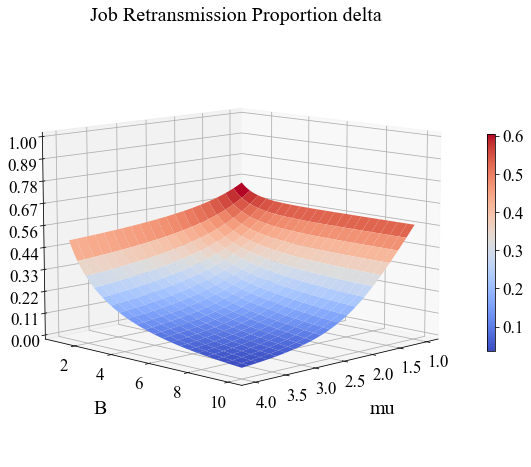

In [259]:
## Plot job retransmission proportion
title_fontsize = 10
tick_size = 17

fig, ax = plt.subplots(figsize=( 12, 8 ), subplot_kw={"projection": "3d"})
surf = ax.plot_surface(mu, B, deltas, rstride=5, cstride=5, cmap='coolwarm')

ax.set_zlim(0.00, 1.00)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter('{x:.02f}')
cb = fig.colorbar(surf, shrink=0.5, aspect=25)
cb.ax.tick_params(labelsize=tick_size)

ax.set_xlabel('mu', fontsize=title_fontsize, labelpad=20)
ax.set_ylabel('B' , fontsize=title_fontsize, labelpad=20)
ax.set_title('Job Retransmission Proportion delta', fontsize=title_fontsize, pad=0)

ax.tick_params(axis='x', labelsize=tick_size)
ax.tick_params(axis='y', labelsize=tick_size)
ax.tick_params(axis='z', labelsize=tick_size)
ax.view_init(elev=10, azim=45)
plt.show()

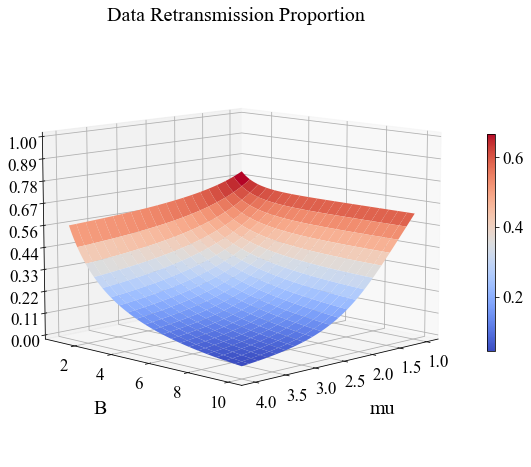

In [247]:
## Plot data retransmission proportion
title_fontsize = 10
tick_size = 17

fig, ax = plt.subplots(figsize=( 12, 8 ), subplot_kw={"projection": "3d"})
surf = ax.plot_surface(mu, B, epsilons, rstride=5, cstride=5, cmap='coolwarm')

ax.set_zlim(0.00, 1.00)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter('{x:.02f}')
cb = fig.colorbar(surf, shrink=0.5, aspect=25)
cb.ax.tick_params(labelsize=tick_size)

ax.set_xlabel('mu', fontsize=title_fontsize, labelpad=20)
ax.set_ylabel('B' , fontsize=title_fontsize, labelpad=20)
ax.set_title('Data Retransmission Proportion', fontsize=title_fontsize, pad=0)

ax.tick_params(axis='x', labelsize=tick_size)
ax.tick_params(axis='y', labelsize=tick_size)
ax.tick_params(axis='z', labelsize=tick_size)
ax.view_init(elev=10, azim=45)
plt.show()

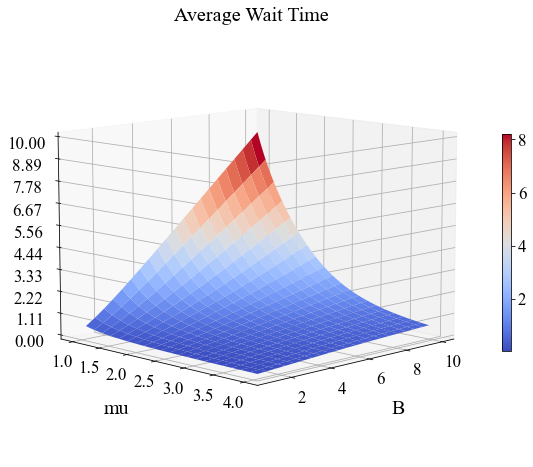

In [274]:
## Plot average wait time
title_fontsize = 10
tick_size = 17

fig, ax = plt.subplots(figsize=( 12, 8 ), subplot_kw={"projection": "3d"})
surf = ax.plot_surface(mu, B, ts, rstride=5, cstride=5, cmap='coolwarm')

ax.set_zlim(0.00, 10)
tmp_planes = ax.zaxis._PLANES 
ax.zaxis._PLANES = ( tmp_planes[2], tmp_planes[3], 
                     tmp_planes[0], tmp_planes[1], 
                     tmp_planes[4], tmp_planes[5])
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter('{x:.02f}')
cb = fig.colorbar(surf, shrink=0.5, aspect=25)
cb.ax.tick_params(labelsize=tick_size)

ax.set_xlabel('mu', fontsize=title_fontsize, labelpad=20)
ax.set_ylabel('B' , fontsize=title_fontsize, labelpad=20)
ax.set_title('Average Wait Time', fontsize=title_fontsize, pad=0)

ax.tick_params(axis='x', labelsize=tick_size)
ax.tick_params(axis='y', labelsize=tick_size)
ax.tick_params(axis='z', labelsize=tick_size, pad=10)
ax.view_init(elev=10, azim=-45)
plt.show()